In [8]:
#New version of numpy is there, using the upgraded one
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle

from math import ceil

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')

#the sales training data has more than 1900 columns
pd.set_option('max_columns', 50)
#These are used for better plotting, check them later or ask about them
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [11]:
input_dir = '/home/aviral/Desktop/retail/m5-forecasting-accuracy/'

#CHECK AGAIN HOW THIS IS WORKING, IS IT ZIP MECHANISM OR SOMETHING ELSE
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [36]:
def read_data(input_dir):
    sell_prices_df = pd.read_csv(input_dir+'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(df=sell_prices_df, verbose=True)
    print('The shape of sell prices is ', sell_prices_df.shape)
    
    sales_train_validation_df = pd.read_csv(input_dir+'sales_train_validation.csv')
    sales_train_validation_df = reduce_mem_usage(df=sales_train_validation_df, verbose=True)
    print('The shape of sales data is ', sales_train_validation_df.shape)
    
    calendar_df = pd.read_csv(input_dir+'calendar.csv')
    calendar_df = reduce_mem_usage(df=calendar_df, verbose=True)
    print('The shape of the calendar is ', calendar_df.shape)
    
    return sell_prices_df, sales_train_validation_df, calendar_df
    

In [37]:
t1 = time.time()
sell_df, sales_df, calendar = read_data(input_dir)
t2 = time.time()
print('Time taken for loading data is ', (t2-t1))

Mem. usage decreased to 130.48 Mb (37.5% reduction)
The shape of sell prices is  (6841121, 4)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
The shape of sales data is  (30490, 1919)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
The shape of the calendar is  (1969, 14)
Time taken for loading data is  91.17874264717102


In [38]:
#Ask rahul about the second column, what does the middle digit represent
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [39]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [40]:
sell_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [24]:
import datetime
#Create a dates list, this will be used in plotting later
date_index = calendar['date']
#Even though the calendar has 1969 dates, the sales data is available for only 1913 days
#The rest of it might be for validation and testing
dates = date_index[0:1819]
dates_list = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [32]:
#This is the aggregated per category and per store
data = pd.DataFrame(sales_df.groupby(by = ['cat_id', 'dept_id', 'item_id', 'store_id']).sum())
data.head(n=15)

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  \
cat_id dept_id item_id     store_id                                           
FOODS  FOODS_1 FOODS_1_001 CA_1        3    0    0    1    4    2    0    2   
                           CA_2        2    0    0    0    1    0    8    0   
                           CA_3        1    2    1    1    1    2    0    1   
                           CA_4        0    1    1    1    1    1    0    0   
                           TX_1        0    1    1    0    0    0    0    0   
                           TX_2        0    0    1    2    0    4    0    0   
                           TX_3        0    0    0    0    0    0    0    0   
                           WI_1        0    2    0    1    0    5    0    0   
                           WI_2        0    0    0    0    0    1    2    1   
                           WI_3        0    0    0    0    0    3    0    0   
               FOODS_1_002 CA_1        0    1    0    1    1    1    0    0   
                           CA_2        2    1    1    0    2    2    0    1   
                           CA_3        1    0    1    2    0    0    0    1   
                           CA_4        0    1    2    1    0    0    0    0   
                           TX_1        0    0    0    0    0    0    0    0   

                                     d_9  d_10  d_11  d_12  d_13  d_14  d_15  \
cat_id dept_id item_id     store_id                                            
FOODS  FOODS_1 FOODS_1_001 CA_1        0     0     0     0     3     1     3   
                           CA_2        4     1     2     1     1     3     4   
                           CA_3        1     1     0     0     3     3     2   
                           CA_4        0     0     0     0     1     2     1   
                           TX_1        2     1     0     0     0     1     0   
                           TX_2        2     2     0     1     2     0     0   
                           TX_3        0     0     4     1     0     0     0   
                           WI_1        1     1     0     0     1     0     2   
                           WI_2        1     1     0     0     0     1     2   
                           WI_3        0     3     0     2     1     4     2   
               FOODS_1_002 CA_1        0     0     1     1     0     2     0   
                           CA_2        0     0     1     0     0     0     5   
                           CA_3        1     0     1     0     0     0     1   
                           CA_4        0     1     0     1     0     0     0   
                           TX_1        0     0     0     1     0     2     1   

                                     d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
cat_id dept_id item_id     store_id                                             
FOODS  FOODS_1 FOODS_1_001 CA_1         0     2     1     2     0     2     1   
                           CA_2         1     2     2     2     0     1     1   
                           CA_3         7     1     2     4     0     1     1   
                           CA_4         0     1     0     0     1     0     2   
                           TX_1         0     0     0     0     0     0     0   
                           TX_2         4     4     1     0     1     2     0   
                           TX_3         0     0     2     1     1     0     1   
                           WI_1         0     0     1     2     0     7     0   
                           WI_2         0     1     1     1     1     4     1   
                           WI_3         6     0     0     0     3     0     2   
               FOODS_1_002 CA_1         1     0     0     0     0     0     0   
                           CA_2         3     0     0     0     0     0     3   
                           CA_3         0     0     0     0     0     1     0   
                           CA_4         0     0     0     1     0     0     0   
                           TX_1     

In [31]:
#The complete sales for the 6 year time period of each item in each of the stores

sales = pd.DataFrame(data.sum(axis = 1))
sales.rename(columns = {0:'sales'},inplace=True)
sales.head(15)

sales
cat_id dept_id item_id     store_id       
FOODS  FOODS_1 FOODS_1_001 CA_1       1503
                           CA_2       2214
                           CA_3       2302
                           CA_4        688
                           TX_1       1119
                           TX_2       1112
                           TX_3        785
                           WI_1       1086
                           WI_2        875
                           WI_3        563
               FOODS_1_002 CA_1        914
                           CA_2       1154
                           CA_3        603
                           CA_4        640
                           TX_1        323

In [35]:
#Same procedure as above, but now the tables are store-wise instead of item-wise
stores_df = pd.DataFrame(sales_df.groupby(by = ['store_id', 'cat_id']).sum())

stores = pd.DataFrame(stores_df.sum(axis=1))
stores.rename(columns = {0:'Total sales'}, inplace=True)
stores

Total sales
store_id cat_id                
CA_1     FOODS        5380828.0
         HOBBIES       876678.0
         HOUSEHOLD    1440710.0
CA_2     FOODS        3480259.0
         HOBBIES       637803.0
         HOUSEHOLD    1567413.0
CA_3     FOODS        7515790.0
         HOBBIES       960947.0
         HOUSEHOLD    2711443.0
CA_4     FOODS        2819425.0
         HOBBIES       564455.0
         HOUSEHOLD     719796.0
TX_1     FOODS        3778209.0
         HOBBIES       429084.0
         HOUSEHOLD    1387999.0
TX_2     FOODS        5015124.0
         HOBBIES       635997.0
         HOUSEHOLD    1563263.0
TX_3     FOODS        4163088.0
         HOBBIES       527258.0
         HOUSEHOLD    1398984.0
WI_1     FOODS        3438352.0
         HOBBIES       655696.0
         HOUSEHOLD    1055014.0
WI_2     FOODS        4768184.0
         HOBBIES       370214.0
         HOUSEHOLD    1405614.0
WI_3     FOODS        4730680.0
         HOBBIES       466668.0
         HOUSEHOLD    1230434.0

Text(0.5, 1.0, 'Store-wise sales across the categories')

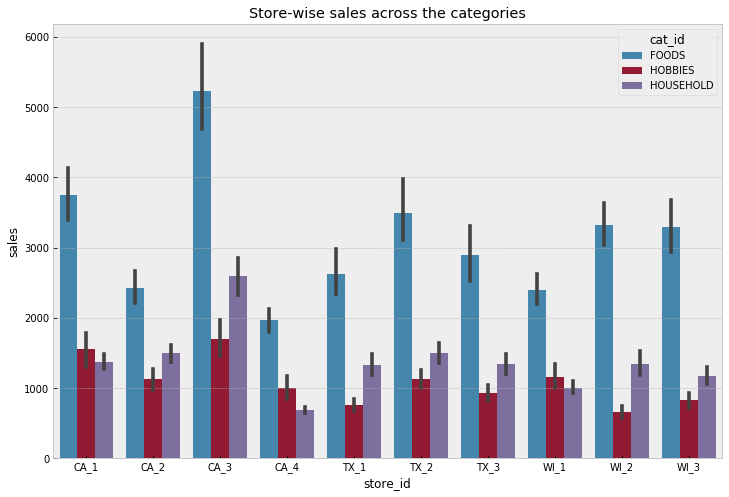

In [44]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.barplot(x= sale['store_id'],y=sale['sales'],hue=sale['cat_id'])
plt.title('Store-wise sales across the categories')
#Ask what the middle lines in each bar plot represent

In [46]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [69]:
#Unable to merge, trying an alternate method
food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))[0].tolist()
hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))[0].tolist()
house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))[0].tolist()

calendar['food'] = food
calendar['hobbies'] = hobbies
calendar['households'] = house
calendar

,key_0,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,food,hobbies,households
0,d_1,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,23178,3764,5689
1,d_2,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,22758,3357,5634
2,d_3,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,17174,2682,3927
3,d_4,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,18878,2669,3865
4,d_5,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,14603,1814,2729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,23632,3472,8239
1909,d_1910,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,23317,3353,8363
1910,d_1911,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,26704,4085,9728
1911,d_1912,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0,31927,4787,12248


In [77]:
# Taking daily Sales data for each each category from each store and merging with calender data.

l1 = ['FOODS','HOBBIES','HOUSEHOLD']
l2 = list(sales_df['store_id'].unique())
for cat in l1:
    for store in l2:
        tmp = pd.DataFrame(data.xs(cat).xs(store,level = 2 ).sum(axis = 0))
        tmp.reset_index(inplace = True)
        tmp.rename(columns = {0:(cat+'_'+store).lower()},inplace = True)
        calendar = pd.concat([calendar,tmp[(cat+'_'+store).lower()]],axis = 1)
        
calendar

,key_0,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,food,hobbies,households,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,...,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3,hobbies_ca_1,hobbies_ca_2,hobbies_ca_3,hobbies_ca_4,hobbies_tx_1,hobbies_tx_2,hobbies_tx_3,hobbies_wi_1,hobbies_wi_2,hobbies_wi_3,household_ca_1,household_ca_2,household_ca_3,household_ca_4,household_tx_1,household_tx_2,household_tx_3,household_wi_1,household_wi_2,household_wi_3
0,d_1,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,23178,3764,5689,3239,2193,3446,1223,1781,2788,2284,...,2788,2284,1581,1615,3028,556,538,550,158,251,385,243,615,190,278,542,763,743,244,524,679,503,508,451,732
1,d_2,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,22758,3357,5634,3137,1921,3535,1269,1903,2870,2257,...,2870,2257,1327,1433,3106,498,397,430,236,264,359,247,443,127,356,520,728,862,272,520,708,502,424,362,736
2,d_3,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,17174,2682,3927,2008,1289,2701,946,1377,2082,1665,...,2082,1665,977,1586,2543,415,368,438,251,107,229,190,323,113,248,393,464,646,189,338,420,370,262,319,526
3,d_4,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,18878,2669,3865,2258,1540,3064,1002,1643,2180,1647,...,2180,1647,935,2013,2596,392,350,424,239,248,359,202,137,124,194,401,434,744,199,367,415,320,179,385,421
4,d_5,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,14603,1814,2729,2032,1278,2761,1107,1329,1890,1383,...,1890,1383,2,967,1854,268,296,364,253,102,257,142,0,58,74,330,368,692,176,263,345,201,0,150,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,23632,3472,8239,2490,2506,3286,1581,1834,2196,2212,...,2196,2212,2290,3005,2232,363,344,534,405,273,373,334,326,276,244,869,841,1415,514,794,815,769,626,913,683
1909,d_1910,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,23317,3353,8363,2533,2261,3056,1629,1777,2239,2151,...,2239,2151,2285,3078,2308,410,271,540,369,219,340,323,397,281,203,766,771,1422,460,780,867,906,642,1034,715
1910,d_1911,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,26704,4085,9728,2960,2871,3409,1751,1922,2547,2370,...,2547,2370,2790,3419,2665,527,485,598,405,271,388,397,415,303,296,900,1101,1616,472,829,967,924,786,1266,867
1911,d_1912,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0,31927,4787,12248,3655,3760,4459,1971,2319,2930,2600,...,2930,2600,3242,3751,3240,670,542,765,390,289,436,497,503,282,413,1252,1582,2195,593,1092,1117,986,1027,1371,1033


In [72]:
#MERGING THE SALES DATA WITH THE CALENDAR
food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))
hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))
house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))

calendar = pd.merge(calendar,food,how = 'left',left_on=calendar['d'],right_on = food.index)
del calendar['key_0']
calendar.rename(columns = {0:'food'},inplace = True)
calendar = pd.merge(calendar,hobbies,how = 'left',left_on=calendar['d'],right_on = hobbies.index)
del calendar['key_0']
calendar.rename(columns = {0:'hobby'},inplace = True)
calendar = pd.merge(calendar,house,how = 'left',left_on=calendar['d'],right_on = house.index)
del calendar['key_0']
calendar.rename(columns = {0:'house'},inplace = True)

ValueError: cannot insert key_0, already exists

In [45]:
grps = cln.groupby(by=['year','month'])
def plot_trend(factor,subplots):
    if subplots == True:
        f, a = plt.subplots(3,2,figsize = (14,10))
        if type(factor) == list:
            for i,fact in enumerate(factor):
                check = grps.agg(fact=(fact,'sum'))
                check.rename(columns = {'fact':factor[i]},inplace=True)
                check.xs(2011).plot(ax=a[0,0])
                check.xs(2012).plot(ax=a[0,1])
                check.xs(2013).plot(ax=a[1,0])
                check.xs(2014).plot(ax=a[1,1])
                check.xs(2015).plot(ax=a[2,0])
                check.xs(2016).plot(ax=a[2,1])
                
        else:
            check = grps.agg({factor:'sum'})
            check.xs(2011).plot(ax=a[0,0])
            check.xs(2012).plot(ax=a[0,1])
            check.xs(2013).plot(ax=a[1,0])
            check.xs(2014).plot(ax=a[1,1])
            check.xs(2015).plot(ax=a[2,0])
            check.xs(2016).plot(ax=a[2,1])
        a[0,0].title.set_text('2011')
        a[0,1].title.set_text('2012')
        a[1,0].title.set_text('2013')
        a[1,1].title.set_text('2014')
        a[2,0].title.set_text('2015')
        a[2,1].title.set_text('2016')
        f.tight_layout()
        f.suptitle('Monthly Sales Trends')
    else:
        fig,ax = plt.subplots(figsize = (20,5))
        for fact in factor:
            cln.set_index('date')[fact].rolling(30).mean().plot(label = fact)
            plt.legend()
            fig.suptitle('30 Day Moving Average')

NameError: name 'cln' is not defined